In [ ]:
!pip install umap

In [1]:
import doctest
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
from sklearn.neighbors import NearestNeighbors
# from geopy.distance import geodesic
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
import umap.umap_ as umap
#from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# two useful data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns
# setup plotting in a notebook in a reasonable way
%matplotlib inline
%config InlineBackend.figure_format='retina'

# default figure aesthetics I'll be using, 
# there are other choices, see seaborn docs
sns.set_style("white")
sns.set_context("notebook")

In [2]:
plt.style.use('dark_background')

### Read in the data

In [3]:
housing_data_df = pd.read_csv(r'clean_housing_data_with_crime_rates.csv')
housing_data_df

,State,City,Street,Zipcode,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,...,house_coordinates,closest_city,city_coordinates,distance_to_maj_city_miles,population_y,violent_crime,prop_crime,larceny,vehicle_theft,difference_listed_vs_estimate
0,AL,Montgomery,Brampton Ln,36117.0,3.0,2.0,1564.0,96.547315,0.2000,150500.0,...,"(32.372746, -86.165115)",Birmingham,"(33.5279, -86.7971)",87.664428,209018.0,0.001893,0.027600,0.017277,0.002520,500.0
1,AL,Montgomery,Crestview Ave,36109.0,3.0,2.0,2196.0,76.958106,0.6100,124700.0,...,"(32.39595, -86.269714)",Birmingham,"(33.5279, -86.7971)",83.806091,209018.0,0.001893,0.027600,0.017277,0.002520,44300.0
2,AL,Montgomery,Narrow Lane Rd,36116.0,3.0,3.0,3693.0,54.156512,6.9000,188300.0,...,"(32.273514, -86.25934)",Birmingham,"(33.5279, -86.7971)",91.920847,209018.0,0.001893,0.027600,0.017277,0.002520,11700.0
3,AL,Montgomery,E Delano Ave,36105.0,3.0,2.0,1428.0,90.966387,0.2600,127500.0,...,"(32.337, -86.29974)",Birmingham,"(33.5279, -86.7971)",87.007986,209018.0,0.001893,0.027600,0.017277,0.002520,2400.0
4,AL,Montgomery,George B Edmondson Dr,36110.0,3.0,1.0,1050.0,65.714286,0.1600,66500.0,...,"(32.40325, -86.28537)",Birmingham,"(33.5279, -86.7971)",83.007626,209018.0,0.001893,0.027600,0.017277,0.002520,2500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,WY,Green River,Colorado Dr,82935.0,5.0,3.0,3068.0,128.748370,0.2200,381000.0,...,"(41.494328, -109.45258)",Provo,"(40.2457, -111.6457)",143.591563,11927.0,0.001845,0.008133,0.007043,0.000168,14000.0
9632,WY,Evansville,Henrie Roadway,82636.0,2.0,2.0,2008.0,343.625498,4.6000,689900.0,...,"(42.86057, -106.10931)",Denver,"(39.762, -104.8758)",223.247715,2977.0,0.002351,0.024521,0.017467,0.002687,100.0
9633,WY,Evansville,6th St,82636.0,4.0,2.0,2022.0,157.270030,0.1828,311100.0,...,"(42.86506, -106.27643)",Denver,"(39.762, -104.8758)",226.191583,2977.0,0.002351,0.024521,0.017467,0.002687,6900.0
9634,WY,Evansville,6th St,82636.0,3.0,3.0,2300.0,143.434783,0.1739,329500.0,...,"(42.86544, -106.27745)",Denver,"(39.762, -104.8758)",226.233434,2977.0,0.002351,0.024521,0.017467,0.002687,400.0


In [4]:
housing_data_df.columns

Index(['State', 'City', 'Street', 'Zipcode', 'Bedroom', 'Bathroom', 'Area',
       'PPSq', 'LotArea', 'MarketEstimate', 'RentEstimate', 'Latitude',
       'Longitude', 'ListedPrice', 'density', 'source', 'military',
       'incorporated', 'timezone', 'ranking', 'zips', 'id',
       'house_coordinates', 'closest_city', 'city_coordinates',
       'distance_to_maj_city_miles', 'population_y', 'violent_crime',
       'prop_crime', 'larceny', 'vehicle_theft',
       'difference_listed_vs_estimate'],
      dtype='object')

In [43]:
# manipulating coordinates to be two separate variables + in separate columns for location purposes
housing_df_revised = housing_data_df[['Bedroom', 'Bathroom', 'Area', 'PPSq', 'LotArea', 'MarketEstimate', 'RentEstimate', 'ListedPrice', 'difference_listed_vs_estimate', 'house_coordinates', 'distance_to_maj_city_miles', 'violent_crime', 'prop_crime', 'larceny', 'vehicle_theft']]
housing_df_revised['x_house_coord'], housing_df_revised['y_house_coord'] = zip(*(housing_df_revised['house_coordinates'].str.strip('()').str.split(', ')))
housing_df_revised['x_house_coord'] = housing_df_revised['x_house_coord'].astype(float)
housing_df_revised['y_house_coord'] = housing_df_revised['y_house_coord'].astype(float)
housing_df_revised.drop(columns=['house_coordinates'], inplace=True)

/var/folders/dr/_3zwgynx02q1l6yd2z7c_p3w0000gn/T/ipykernel_20120/1025807139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['x_house_coord'], housing_df_revised['y_house_coord'] = zip(*(housing_df_revised['house_coordinates'].str.strip('()').str.split(', ')))
/var/folders/dr/_3zwgynx02q1l6yd2z7c_p3w0000gn/T/ipykernel_20120/1025807139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['x_house_coord'], housing_df_revised['y_house_coord'] = zip(*(housing_df_revised['

In [44]:
housing_df_revised.columns

Index(['Bedroom', 'Bathroom', 'Area', 'PPSq', 'LotArea', 'MarketEstimate',
       'RentEstimate', 'ListedPrice', 'difference_listed_vs_estimate',
       'distance_to_maj_city_miles', 'violent_crime', 'prop_crime', 'larceny',
       'vehicle_theft', 'x_house_coord', 'y_house_coord'],
      dtype='object')

In [45]:
for var in housing_df_revised.columns:
    print(type(housing_df_revised[var][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [46]:
housing_df_matrix = housing_df_revised.values
housing_df_matrix

array([[ 3.00000000e+00,  2.00000000e+00,  1.56400000e+03, ...,
         2.51987867e-03,  3.23727460e+01, -8.61651150e+01],
       [ 3.00000000e+00,  2.00000000e+00,  2.19600000e+03, ...,
         2.51987867e-03,  3.23959500e+01, -8.62697140e+01],
       [ 3.00000000e+00,  3.00000000e+00,  3.69300000e+03, ...,
         2.51987867e-03,  3.22735140e+01, -8.62593400e+01],
       ...,
       [ 4.00000000e+00,  2.00000000e+00,  2.02200000e+03, ...,
         2.68726906e-03,  4.28650600e+01, -1.06276430e+02],
       [ 3.00000000e+00,  3.00000000e+00,  2.30000000e+03, ...,
         2.68726906e-03,  4.28654400e+01, -1.06277450e+02],
       [ 4.00000000e+00,  2.00000000e+00,  2.12000000e+03, ...,
         2.51572327e-03,  4.28510060e+01, -1.06391810e+02]])

### Scale the data

In [47]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
housing_df_matrix_scaled = StandardScaler().fit_transform(housing_df_matrix)

### Generate umap

##### Split into training and testing set

In [48]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
umap_result = umap_model.fit_transform(housing_df_matrix_scaled)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


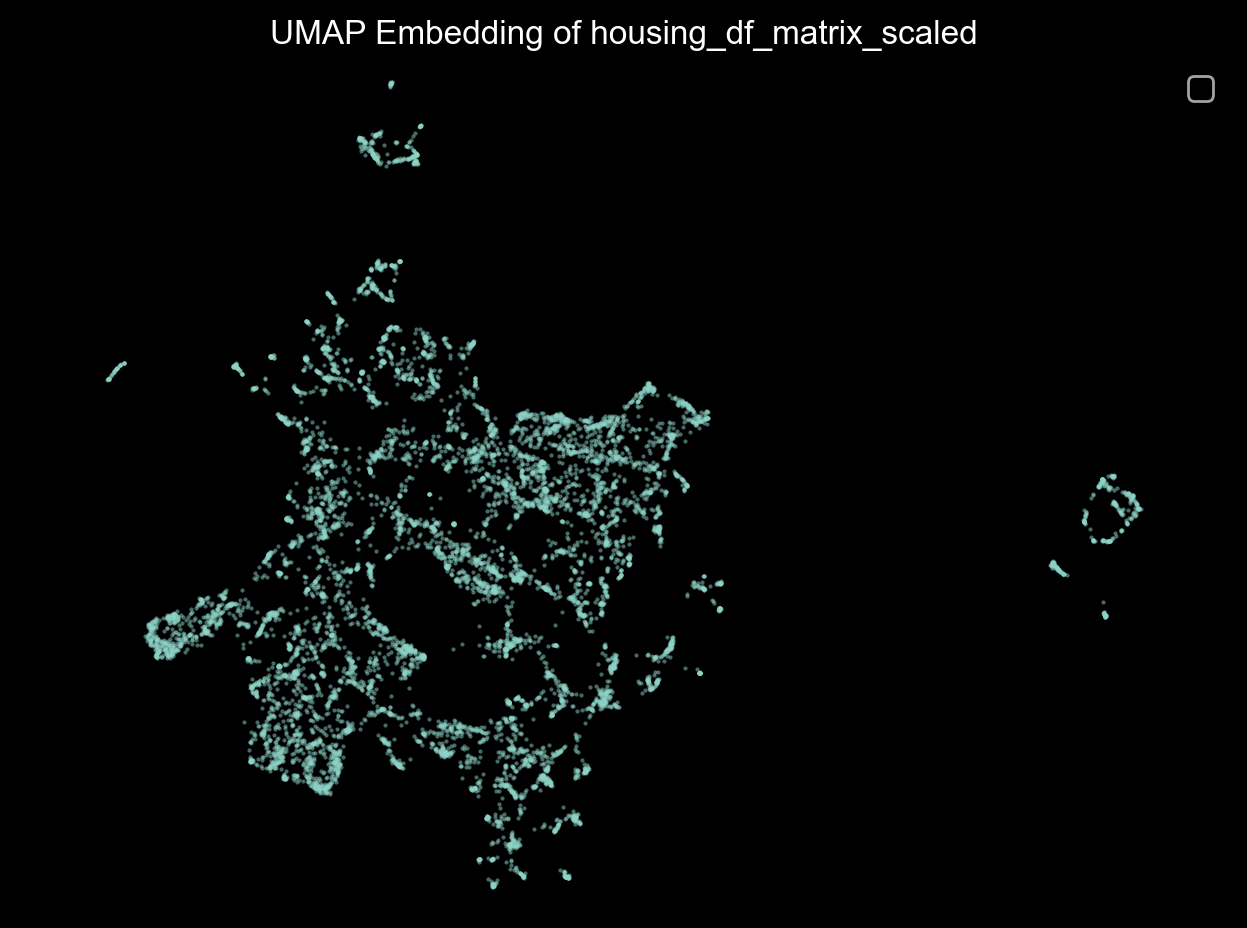

In [49]:
plt.scatter(umap_result[:, 0], umap_result[:, 1], marker='.', alpha=0.5, s = 1)
plt.title('UMAP Embedding of housing_df_matrix_scaled')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.axis("off")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()


### determine clusters

DBSCAN

In [52]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.25, min_samples=5)
labels = dbscan.fit_predict(umap_result)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


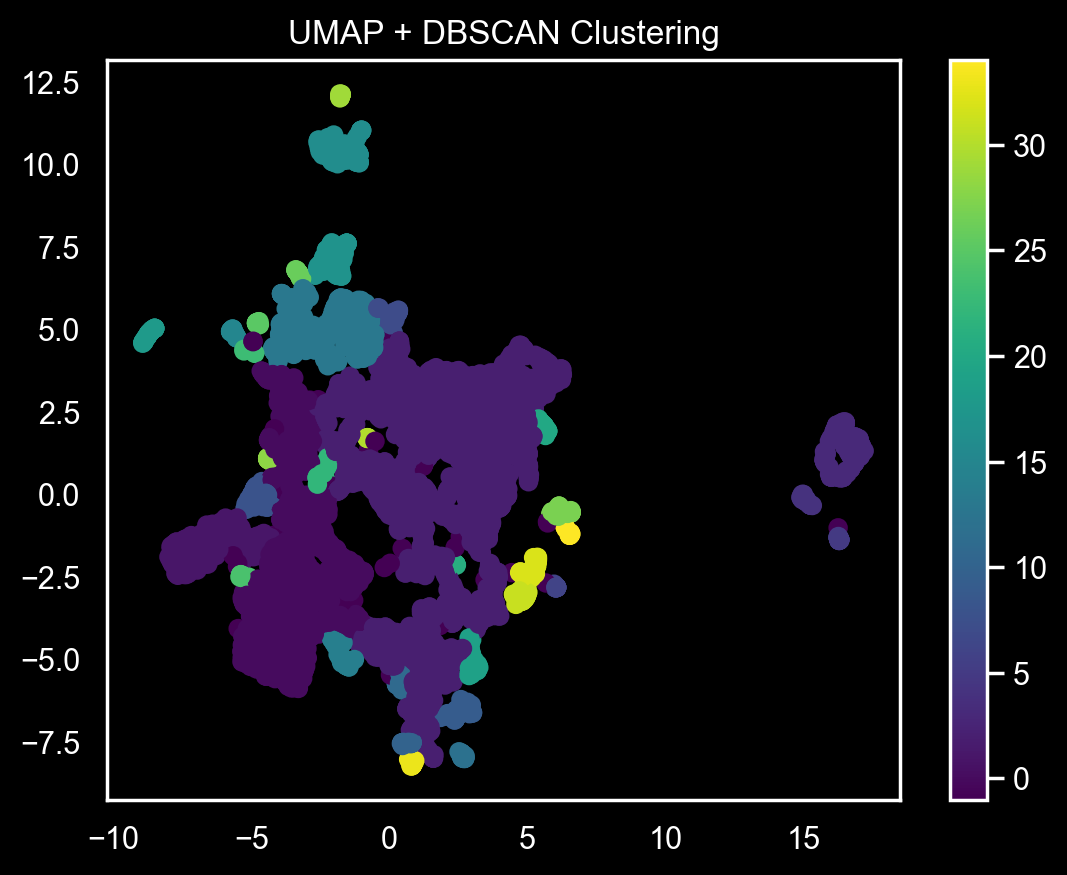

In [53]:
# plotting the clusters
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='viridis')
plt.title('UMAP + DBSCAN Clustering')
plt.colorbar()
plt.show()


### Hierarchical clustering // KNN

### Run testing dataset 


### Calculate sillouette score for each clustering algorithm


In [54]:
# sillouette score


### eyeball to evaluate the algorithms (model.predict) with 